In [29]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re
from collections import defaultdict
import pickle
from statsmodels.distributions.empirical_distribution import ECDF
import math

%matplotlib inline
import matplotlib.pyplot as plt

1.Сформулируйте нулевые и альтернативные гипотезы и проведите следующие тесты:

1.1 Одновыборочный параметрический тест

1.2 Двухвыборочный параметрический и непараметрический тесты

1.3 Параметрический и непараметрический тесты для парных наблюдений

Из пяти перечисленных тестов как минимум два нужно сделать вручную (т.е. статистику для теста нужно посчитать самостоятельно, без использования готовой функции из пакета)

2.Сформулируйте точную альтернативную гипотезу для одного из проведенных тестов и оцените мощность теста

3.Рассматривая проведенные тесты как единую группу, сделайте поправку на множественное тестирование (FDR, Bonferroni, Sidak, Bonferroni-Holm). Изменились ли результаты?

4.Постройте параметрические доверительные интервалы для среднего и непараметрические интервалы для медианы на основе бутстрепа

Группы для тестов можно выделять по полям JobTitle, AgencyTitle.



In [3]:
data = pd.read_csv('salaries.csv', sep=',')
data.head()

,Unnamed: 0,Unnamed: 0.1,Agency,AgencyTitle,EmployeeName,JobTitle,Salary2010,Salary2011,Salary2012,Salary2013
0,2,10,165,Accountancy,"JOLICOEUR, EDWIN G",BOARD MEMBER,750,950,450,300
1,5,36,165,Accountancy,"SWEENEY, RICK",EXEC. DIRECTOR,92573,91078,91536,92952
2,6,44,35,Actuary,"BURKHART, KELLY RAE",ADMINISTRATIVE SERVICES MANAGER,78905,77458,76560,78726
3,7,45,35,Actuary,"DEMPSEY, TROY A",SENIOR ACTUARIAL ANALYST,81542,86883,105468,66491
4,8,47,35,Actuary,"GUTIERREZ, AARON",POLICY ANALYST,69468,68703,67656,69570


# 1.1 Одновыборочный параметрический тест

На основе наших данных найдём среднюю зарплату за 2010 год. Далее, с помощью критерия Стьюдента проверим, как соотносится полученное среднее $\mu$ с выборочным средним по агенству "Labor and Industries" $\mu_{0}$

$$H_{0}: \mu_{0} = \mu \\ H_{1}: \mu_{0} \not= \mu$$

In [57]:
data_LaI = data[data['AgencyTitle'].isin(['Labor and Industries'])]
data_LaI_salary = data_social.Salary2010
data_salary = data.Salary2010

Посмотрим, как выглядят наши распределения

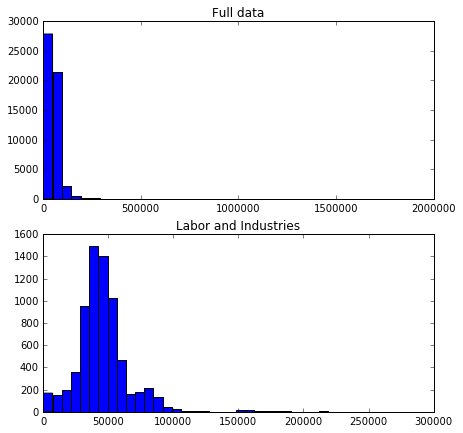

In [103]:
plt.figure(figsize=(7, 7))
plt.subplot(2,1, 1)
plt.hist(data_salary, bins=int(np.sqrt(len(data_social_2010)))/2)
plt.title("Full data")
plt.subplot(2,1, 2)
plt.hist(data_LaI_salary, bins=int(np.sqrt(len(data_social_2013)))/2)
plt.title("Labor and Industries")

По графикам видно, что верна гипотеза $H_1$, проверим:

$$ t=\frac{\bar X-\mu}{\frac{s_{X}}{\sqrt{n}}},\\s^{2}_{X}=\frac{1}{n-1}\sum\limits^{n}_{t=1}(X_{t}-\bar X)^{2}$$

In [80]:
def s2(x):
    s = 0.0
    mu = x.mean()
    for elem in x:
        s += (elem - mu)**2
    return s/(len(x)-1)

def student(x,mu):
    mu0 = x.mean()
    return (mu0-mu)/math.sqrt(s2(x)/len(x))

In [82]:
statistic = student(data_LaI_salary, data_salary.mean())

In [141]:
single_student = stats.ttest_1samp(data_LaI_salary, data_salary.mean()).pvalue

При нулевой гипотезе распределение этой статистики t(n-1). Следовательно, при превышении значения статистики по абсолютной величине критического значения данного распределения нулевая гипотеза отвергается.

Зададим уровень значимость $\alpha = 0.05$ и найдём критическое значение:

In [83]:
critical = stats.t.isf(0.05,len(data_LaI_salary)-1)
print critical
print statistic

1.6450696704
-12.9608516751


In [84]:
if abs(statistic) > critical:
    print "Гипотеза H_0 --- отвергается"
else:
    print "Гипотеза H_0 --- не отвергается"

Гипотеза H_0 --- отвергается


Таким образом наше предположение $H_0$ --- не верно, поэтому принимаем гипотезу $H_1$: среднее значение зарплат по всем агенствам отличается от выборочного среднего по агенству "Labor and Industries"

# 1.2.1 Двухвыборочный параметрический тест

Предположим, что расспределение зарплат за 2010 и 2013 годы у агенства Social and Health Services не изменилось. Таким образом 
$$ H_0: \mu_{2010} = \mu_{2013} \\ H_1: \mu_{2010} \not= \mu_{2013}$$

In [6]:
data_social = data[data['AgencyTitle'].isin(['Social and Health Services'])]
data_social_2010 = data_social.Salary2010
data_social_2013 = data_social.Salary2013

Посмотрим на, то как выглядят распределения:

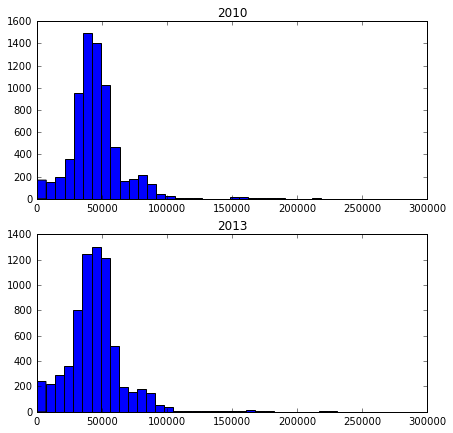

In [13]:
plt.figure(figsize=(7, 7))
plt.subplot(2,1, 1)
plt.hist(data_social_2010, bins=int(np.sqrt(len(data_social_2010)))/2)
plt.title("2010")
plt.subplot(2,1, 2)
plt.hist(data_social_2013, bins=int(np.sqrt(len(data_social_2013)))/2)
plt.title("2013")

In [23]:
mu2010 = data_social_2010.mean()
mu2013 = data_social_2013.mean()
print "mu_2010 = %.02lf, mu_2013 = %.02lf"%(mu2010,mu2013)

mu_2010 = 45979.80, mu_2013 = 45399.55


Для оценки воспользуемся критерием Стьюдента для двух независимых выборок.

$$ t=\frac{\bar{X}_{1}-\bar{X}_{2}}{\sqrt{\frac{s_{1}^2}{n_1} + \frac{s_{2}^2}{n_2}}}
\\s^{2}_{X}=\frac{1}{n-1}\sum\limits^{n}_{t=1}(X_{t}-\bar X)^{2}$$

In [67]:
def student2(x1,x2):
    numerator = x1.mean() - x2.mean()
    denominator = math.sqrt(s2(x1)/len(x1) + s2(x2)/len(x2))
    return numerator/denominator

In [68]:
statistic2 = student2(data_social_2010,data_social_2013)

In [142]:
double_student = stats.ttest_ind(data_social_2010,data_social_2013).pvalue

Эта статистика при справедливости нулевой гипотезы имеет распределение t(df):

$$df = \frac{\left(\frac{s_1^2}{n_1} +\frac{s_2^2}{n_2} \right)^2}{\frac{\left(\frac{s_1^2}{n_1}\right)^2}{n_1-1} + \frac{\left(\frac{s_2^2}{n_2}\right)^2}{n_2-1} }$$

In [69]:
def count_df(x1,x2):
    s_1 = s2(x1)
    s_2 = s2(x2)
    n_1 = len(x1)
    n_2 = len(x2)
    numerator = (s_1/n_1 + s_2/n_2)**2
    denominator = ((s_1/n_1)**2)/(n_1-1) +  ((s_2/n_2)**2)/(n_1-1)
    return int(numerator/denominator)

In [70]:
df = count_df(data_social_2010,data_social_2013)

Найдём критическое значение распределения Стьюдента для доверительного значения $\alpha = 0.05$ для нашей системы:

In [74]:
critical2 = stats.t.isf(0.05,df)

In [75]:
if abs(statistic2) > critical2:
    print "Гипотеза H_0 --- отвергается"
else:
    print "Гипотеза H_0 --- не отвергается"

Гипотеза H_0 --- не отвергается


Таким образом можем сказать, что распределение зарплат за 2010 и 2013 годы у агенства Social and Health Services не изменилось, что также видно на графиках. 

# 1.2.2 Двухвыборочный непараметрический тест

С помощью критерия Пирсона проверим, коррелируют ли зарплаты для Western Washington University в 2010 и 2013 годах:

$H_0:$ -- не коррелируют, $H_1$ --- коррелируют

In [97]:
data_WWU = data[data['AgencyTitle'].isin(['Western Washington University'])]
data_WWU_2010 = data_WWU.Salary2010
data_WWU_2013 = data_WWU.Salary2013

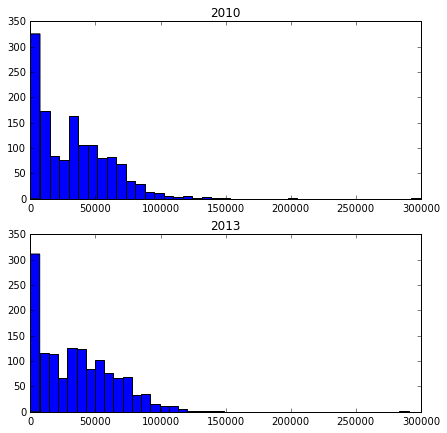

In [102]:
plt.figure(figsize=(7, 7))
plt.subplot(2,1, 1)
plt.hist(data_WWU_2010, bins=int(np.sqrt(len(data_social_2010)))/2)
plt.title("2010")
plt.subplot(2,1, 2)
plt.hist(data_WWU_2013, bins=int(np.sqrt(len(data_social_2013)))/2)
plt.title("2013")

In [147]:
pearsonr = stats.pearsonr(data_WWU_2010,data_WWU_2013)[1]
print pearsonr

0.0


Таким образом явно видно, что зарплаты в 2013 году зависят от зарплат в 2010, гипотеза $H_0$ отвергается.

# 1.3.1 Параметрический тест для парных наблюдений

Предположим, что расспределение зарплат за 2010 и 2013 годы у агенства University of Washington не изменилось. Таким образом 
$$ H_0: \mu_{2010} = \mu_{2013} \\ H_1: \mu_{2010} \not= \mu_{2013}$$

In [101]:
data_uni = data[data['AgencyTitle'].isin(['University of Washington'])]
data_uni_2010 = data_uni.Salary2010
data_uni_2013 = data_uni.Salary2013

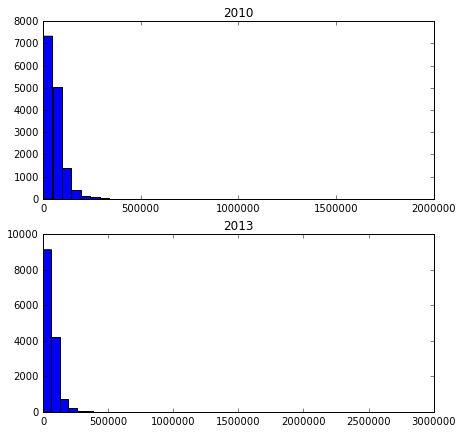

In [104]:
plt.figure(figsize=(7, 7))
plt.subplot(2,1, 1)
plt.hist(data_uni_2010, bins=int(np.sqrt(len(data_social_2010)))/2)
plt.title("2010")
plt.subplot(2,1, 2)
plt.hist(data_uni_2013, bins=int(np.sqrt(len(data_social_2013)))/2)
plt.title("2013")

In [109]:
def student_par(x1,x2):
    x = np.array(x1) - np.array(x2)
    numerator = x.mean()
    denominator = math.sqrt(s2(x)/len(x))
    return numerator/denominator

In [118]:
statistic_par = student_par(data_uni_2010,data_uni_2013)

In [143]:
student_par = stats.ttest_ind(data_uni_2010,data_uni_2013).pvalue

Найдём критическое значение распределения Стьюдента для доверительного значения $\alpha = 0.05$ для нашей системы:

In [121]:
critical2 = stats.t.isf(0.05,len(data_uni_2010)-1)

In [120]:
if abs(statistic_par) > critical2:
    print "Гипотеза H_0 --- отвергается"
else:
    print "Гипотеза H_0 --- не отвергается"

Гипотеза H_0 --- отвергается


Таким образом можем сказать, что распределение зарплат за 2010 и 2013 годы у агенства University of Washington заметно изменилось, что также видно на графиках.

# 1.3.2 Непараметрический тест для парных наблюдений

А теперь проведём исследование гипотез $H_0$ и $H_1$ из пункта 1.3.1 с помощью непараметрического Т-критерия Вилкоксона:

In [144]:
wilcoxon = stats.wilcoxon(data_uni_2010,data_uni_2013).pvalue
print "P_value = %0.2lf"%(wilcoxon)

P_value = 0.00


Данный тест снова подтвердил, что распределение зарплат за 2010 и 2013 у агенства University of Washington  изменилось.

# 2  Мощность теста



2 Сформулируйте точную альтернативную гипотезу для одного из проведенных тестов и оцените мощность теста


Как и везде ранее, установим уровень значимости $\alpha = 0.05$. 

Вычислим, сколько нужно минимально единиц в выборке, чтобы можно было принять или не принять гипотезу $H_{0}$ (пусть это будет гипотеза, что среднее меньше или равно некоторого наперёд заданного значения).

Рассмотрим тест 1.1

In [167]:
def t_test_power(dataframe, mu0):
    mu = dataframe.mean()
    n = len(dataframe)
    SX = 0.0
    for value in dataframe.iteritems():
        SX+=(value[1]-mu)**2/(n-1)
    n_min = SX * np.power(stats.norm.ppf(0.95)+stats.norm.ppf(0.95), 2)/float((mu-mu0)**2)
    print "minimum quantity in relisation", n_min, "in our test", n
    bar_x = mu0+stats.norm.ppf(0.95)*(np.sqrt(SX/n))
    power = 1 - stats.norm.cdf((bar_x-mu)/(np.sqrt(SX/n)))
    return power

t_test_power(data_LaI_salary, data_salary.mean())


minimum quantity in relisation 454.511045519 in our test 7055


0.0

Посмотрим, как отреагирует тест на мощность из библиотеки:

In [168]:
stats.power_divergence(data_LaI_salary, data_salary.mean())

Power_divergenceResult(statistic=71040773.761513487, pvalue=0.0)

Таким образом можно сказать, что мощность теста для данной гипотезы очень мала.

# 3. Прицип Бонферрони

Метод достаточно прост: мы рассчитываем p-value для каждой гипотезы в отдельности и отвергаем "глобальную" нулевую гипотезу только в том случае, если минимальное p-value меньше чем $\alpha /n$.

Всего у нас было 5 тестов:

In [148]:
tests_pval = (single_student, double_student, pearsonr, student_par,wilcoxon)
print min(tests_pval)

0.0


Таким образом гллбальную гипотезу мы можем сразу отвергнуть.

Поправка на принцип Бонферрони:

In [149]:
for index,i in enumerate(tests_pval):
    if i < 0.01:
        print str(index) + " отвергается"
    else:
        print str(index) + " принимается"

0 отвергается
1 принимается
2 отвергается
3 отвергается
4 отвергается


Таким образом в результате поправки ничего не изменилось.

# 4. Bootstrap

In [173]:
from sklearn.utils import resample

median_initial = np.median(data_salary)

errs = []
for i in xrange(1000):
    errs.append(median_initial-resample(data_salary, replace=True).median())
    
a = np.percentile(np.sort(errs), 95)
b = np.percentile(np.sort(errs), 5)

In [176]:
print [b,a]

[-282.0, 178.09999999999991]


In [179]:
mean_initial = np.mean(data_salary)

errs = []
for i in xrange(1000):
    errs.append(mean_initial-resample(data_salary, replace=True).mean())
    
a = np.percentile(np.sort(errs), 95)
b = np.percentile(np.sort(errs), 5)

In [180]:
print [b,a]

[-247.26790225045806, 236.22344706828008]
